<a href="https://www.kaggle.com/code/dascient/yahoo-s-top-gainers-kalman-forecasting-model?scriptVersionId=146976215" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Information and market data collected from Yahoo - https://finance.yahoo.com/gainers/
## Please do not consider the recommendations below as valid. Trade at your own discretion. 

In [1]:
# source
# https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install plotly
!pip install yfinance
!pip install schedule
!pip install pykalman
!pip install pandas_ta
from IPython.display import clear_output
import plotly.graph_objects as go
import schedule,warnings,time,ast
from pykalman import KalmanFilter
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from dateutil.tz import tzlocal
from rich import print, pretty
from datetime import datetime
from random import randint
from random import seed
import pandas_ta as ta
import yfinance as yf
import pandas as pd
import numpy as np
import lxml.html
import requests
import os

clear_output()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def calculate_symbol(df):
    
    df['close'] = df['Close']
    df['low'] = df['Low']
    df['high'] = df['High']
    df['open'] = df['Open']
    
    close = df['close'][len(df)-1]
    low = df['low'][len(df)-1]

    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                      observation_matrices = [1],   # The value for Ht.
                      initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                      initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                      observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                      transition_covariance=.01)    # A small turbulence in the random walk parameter 1.0
    # Get the Kalman smoothing
    state_means, _ = kf.filter(df['close'].values)
    # Call it kf_mean
    df['kf_mean'] = np.array(state_means)
    kalman = df.kf_mean[len(df)-1]
    aboveKalman = low > kalman


    # exponential moving averages 
    ema_13 = df.ta.ema(13, append=True)[-1:].reset_index(drop=True)[0]
    ema_31 = df.ta.ema(31, append=True)[-1:].reset_index(drop=True)[0]
    ema_crossover = ema_13 > kalman


    # lower/upper 14-day bollinger bands for mean reversion
    bbl_14 = df.ta.bbands(length=14, append=True)[['BBL_14_2.0']].tail(1).values[0][0]
    bbu_14 = df.ta.bbands(length=14, append=True)[['BBU_14_2.0']].tail(1).values[0][0]
    bband_buy = close < bbl_14
    bband_sell = close > bbu_14


    # ichimoku 9 & 26-day forecasts 
    # https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.trend.IchimokuIndicator
    isa_9 = df.ta.ichimoku()[1]['ISA_9'].tail(1).values[0] # help(ta.ichimoku)
    isb_26 = df.ta.ichimoku()[1]['ISB_26'].tail(1).values[0]


    # archer ma 
    # https://github.com/twopirllc/pandas-ta#general
    amat = (df.ta.amat()['AMATe_LR_8_21_2'].tail(1).values[0] == 1)


    # rsi
    rsi = df.ta.rsi()[len(df)-1]
    rsi_buy = rsi < 30
    rsi_sell = rsi > 70


    # choppy
    # https://github.com/twopirllc/pandas-ta#trend-18
    try: 
        chop = "{:.2f}".format(df.ta.chop()[len(df.ta.chop())-1]) 
    except RunTimeWarning:
        chop = 0


    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
    # signal
    #buy = (close < isa_9) & (close < isb_26) & amat & rsi_buy & bband_buy & aboveKalman
    
    # kalman is accounted for in the ema_crossover
    buy = amat & ema_crossover# & aboveKalman

    #sell = (close > isa_9) & (close > isb_26) & ~amat & rsi_sell & bband_sell & ~aboveKalman
    
    # kalman is accounted for in the ema_crossover
    sell = ~amat & ~ema_crossover# & ~aboveKalman
    
    return df, close, isa_9, isb_26, chop, rsi, amat, ema_crossover, buy, sell, aboveKalman

# plotter
def plot(df,symbol):
    fig = go.Figure(go.Candlestick(x=df.index,
                                   open=df['open'],
                                   high=df['high'],
                                   low=df['low'],
                                   close=df['close'],
                                   name=symbol,
                                  ))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['kf_mean'], 
                             opacity=0.7, 
                             line=dict(color='purple', width=2), 
                             name='Kalman Filter'))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_13'], 
                             opacity=0.7, 
                             line=dict(color='orange', width=2), 
                             name='EMA_13'))
    
    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_31'], 
                             opacity=0.7, 
                             line=dict(color='lightblue', width=2), 
                             name='EMA_31 '))
    
    fig.update_layout(title=f'Ticker: {symbol}')
    fig.update_layout(xaxis_rangeslider_visible=False)
    return fig.show()

# [Fear & Greed Index](https://www.cnn.com/markets/fear-and-greed)

In [3]:
!pip install fear-and-greed
clear_output()

import fear_and_greed
#type(fear_and_greed.get())

print('\nIndex: ',fear_and_greed.get()[0])
print('Range: ',fear_and_greed.get()[1])
print('Datetime: ',fear_and_greed.get()[2])

Index:  35.4857142857143

Range:  fear

Datetime:  2023-10-17 00:00:00+00:00

# Today's Yahoo Gainers 
## Including Recommendations, Candlesticks, Closing Price, Ichimoku 9 & 26 Day Spans, Choppiness, RSI, Exponential Moving Averages (EMA) & Kalman Forecast Predictors. 
### This notebook only plots entry & exit stocks out of the 100 from Yahoo's Gainers webpage.

In [4]:
from datetime import datetime
today = pd.Timestamp(datetime.now(), tz='EST').strftime("%Y-%m-%d")
print(f"Calculating indicators for today's date: {today}.")

Calculating indicators for today's date: 2023-10-17.

# Entry Points

Entry Points

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: OLK

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 24.954999923706055

Ichimoku 9-Day Forecast: 19.575000047683716

Ichimoku 26-Day Forecast: 19.550000190734863

Choppiness (%): 25.06

RSI: 84.84412884239376

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

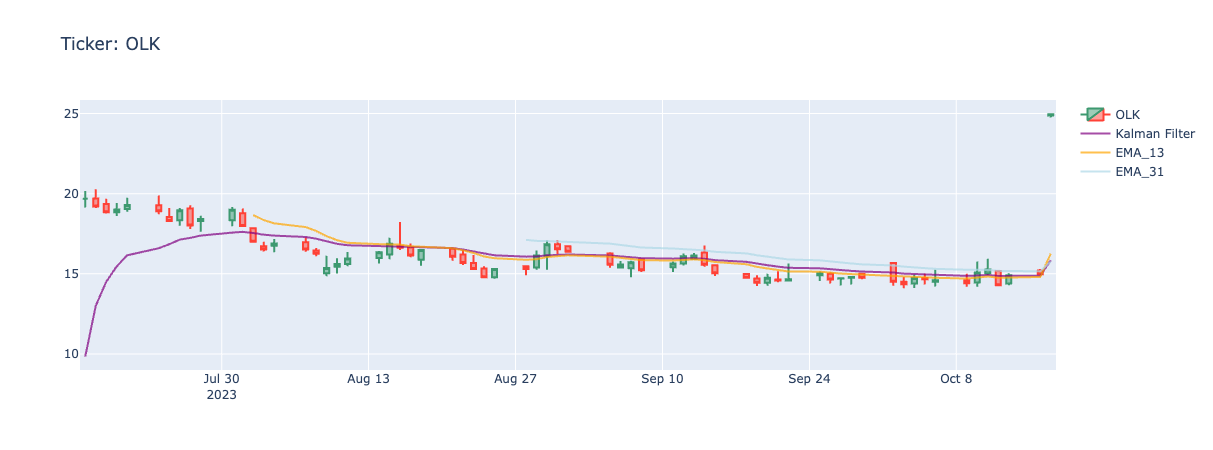

Ticker: AGL

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 20.0049991607666

Ichimoku 9-Day Forecast: 18.890000343322754

Ichimoku 26-Day Forecast: 18.97000026702881

Choppiness (%): 48.36

RSI: 64.5417583411736

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

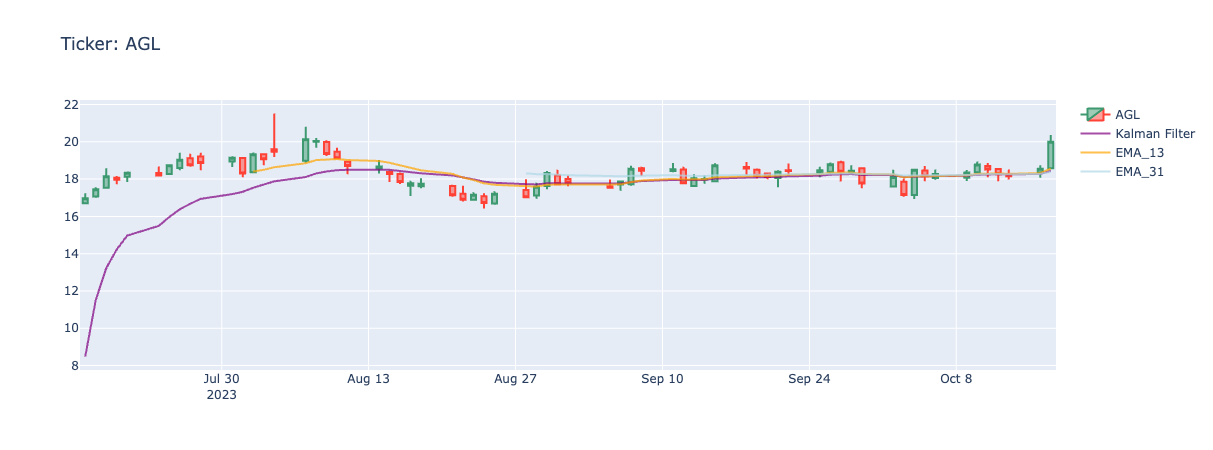

Ticker: TTDKF

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 39.650001525878906

Ichimoku 9-Day Forecast: 37.322500228881836

Ichimoku 26-Day Forecast: 36.82000160217285

Choppiness (%): 32.48

RSI: 66.36347425003322

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

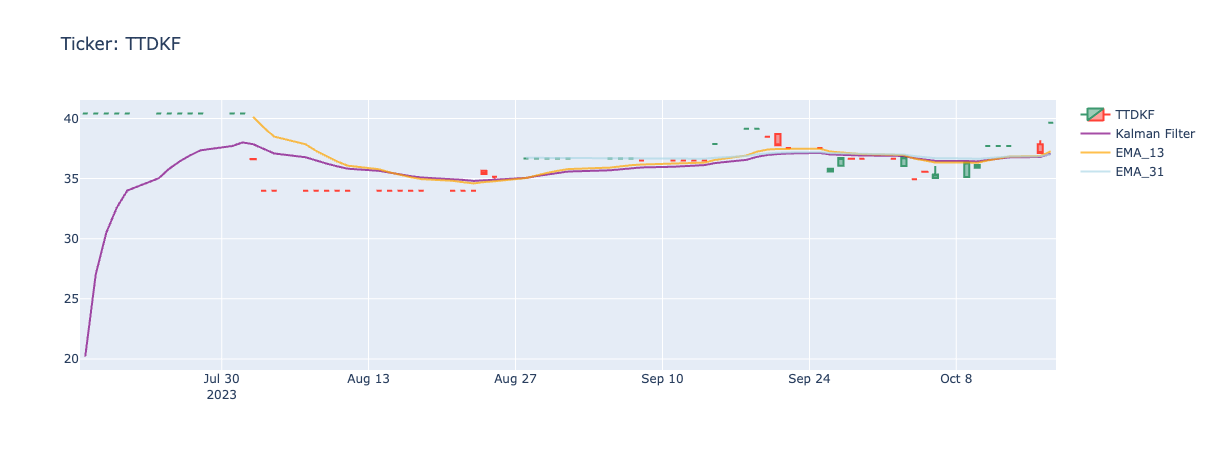

Ticker: SYM

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 46.09000015258789

Ichimoku 9-Day Forecast: 38.71994924545288

Ichimoku 26-Day Forecast: 44.125000953674316

Choppiness (%): 33.25

RSI: 69.86478138146029

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

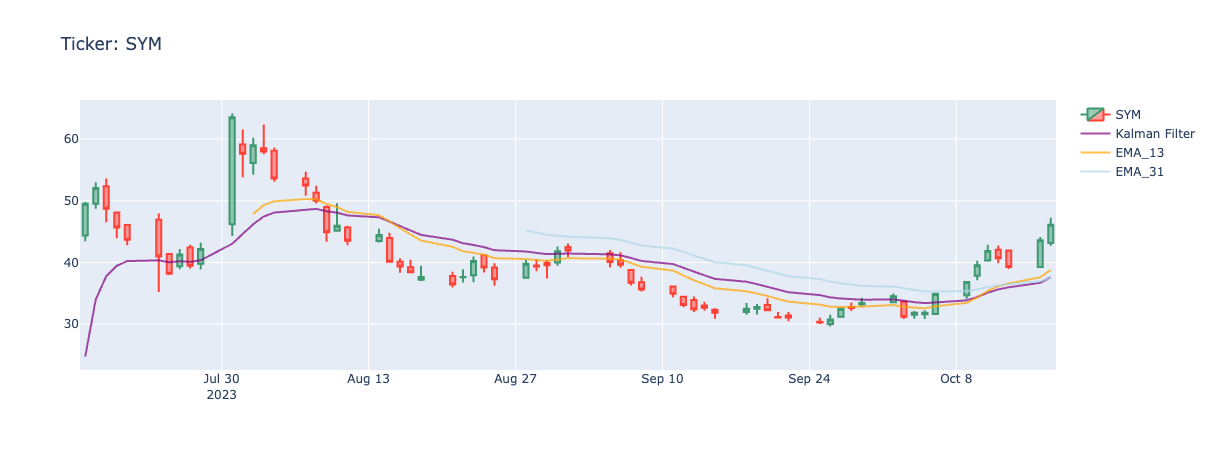

Ticker: AZTA

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 52.72999954223633

Ichimoku 9-Day Forecast: 50.44000053405762

Ichimoku 26-Day Forecast: 53.53999900817871

Choppiness (%): 52.42

RSI: 61.166584356140575

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: False

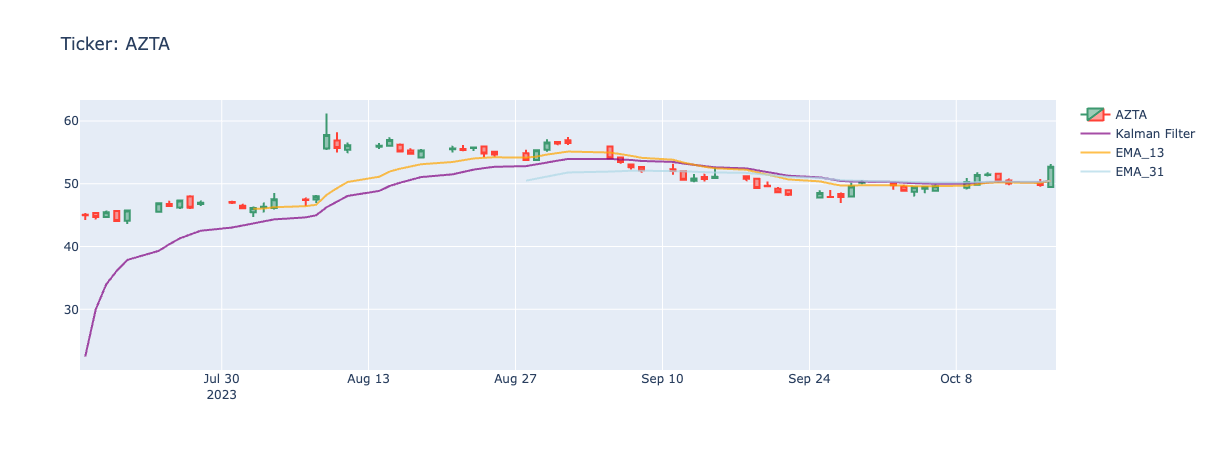

Ticker: PAM

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 42.79499816894531

Ichimoku 9-Day Forecast: 39.088748931884766

Ichimoku 26-Day Forecast: 42.06999969482422

Choppiness (%): 44.50

RSI: 61.199351967940515

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

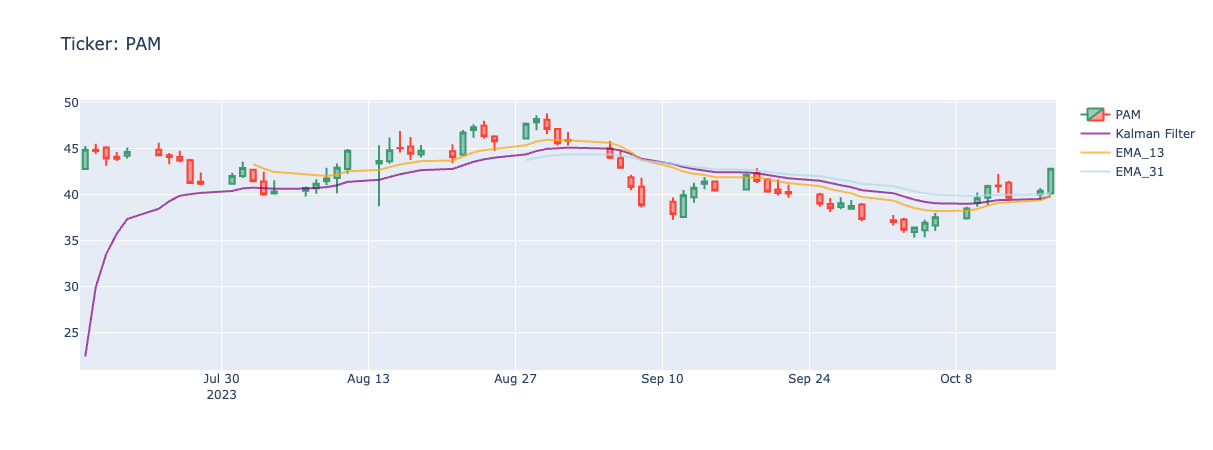

Ticker: GSHD

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 74.36000061035156

Ichimoku 9-Day Forecast: 72.95000076293945

Ichimoku 26-Day Forecast: 68.89000129699707

Choppiness (%): 47.39

RSI: 57.46702766554141

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: False

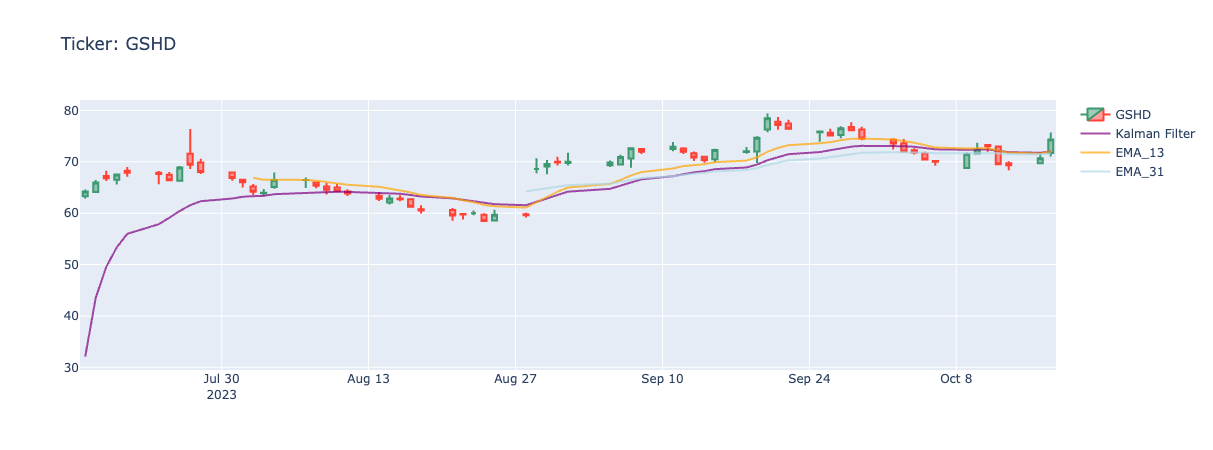

Ticker: FWRD

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 78.22000122070312

Ichimoku 9-Day Forecast: 73.39999961853027

Ichimoku 26-Day Forecast: 86.72500038146973

Choppiness (%): 33.97

RSI: 68.4186992212291

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

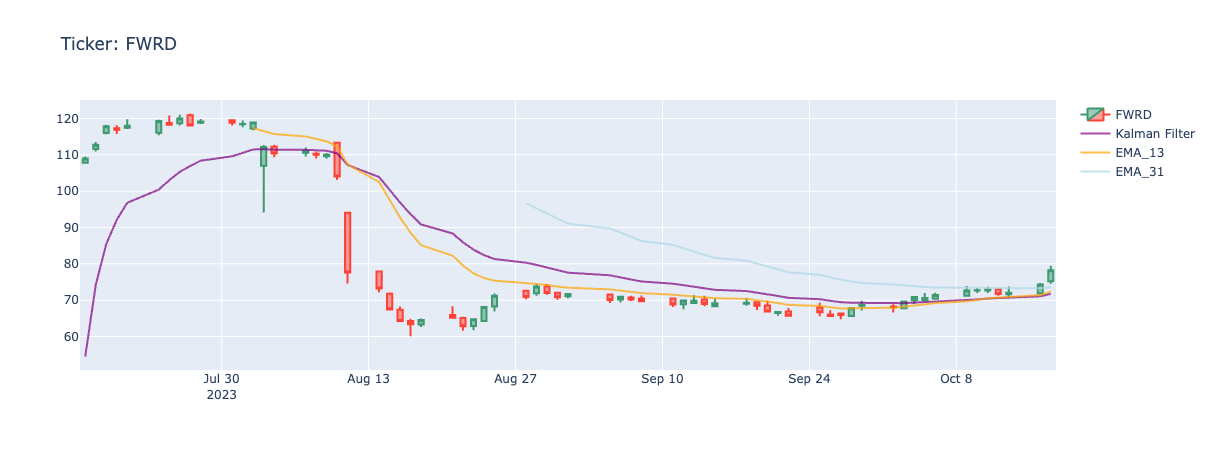

Ticker: GTLB

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 49.45000076293945

Ichimoku 9-Day Forecast: 47.14324951171875

Ichimoku 26-Day Forecast: 47.9950008392334

Choppiness (%): 56.08

RSI: 58.881492531488156

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: False

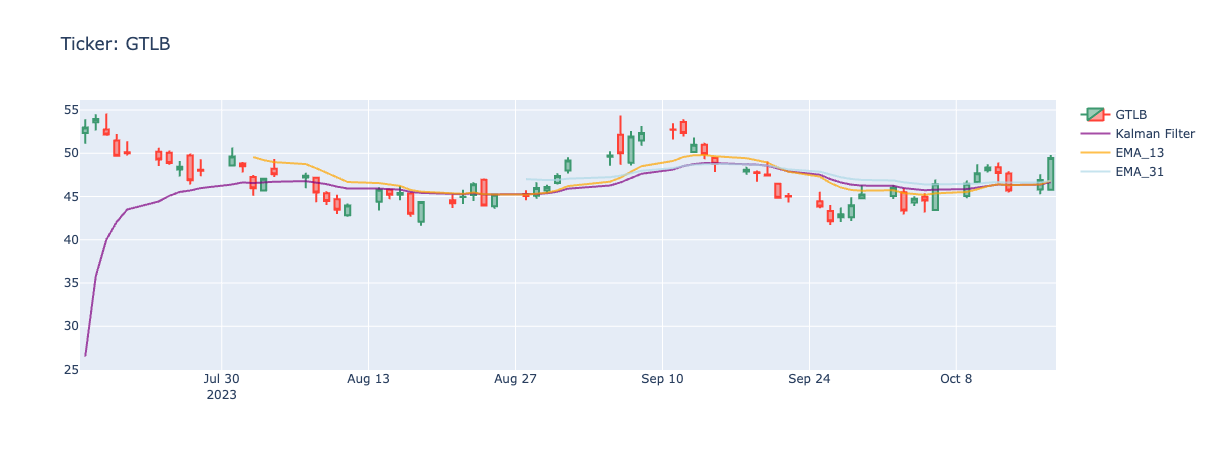

Ticker: STRL

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 76.76499938964844

Ichimoku 9-Day Forecast: 72.39999771118164

Ichimoku 26-Day Forecast: 71.90999984741211

Choppiness (%): 48.85

RSI: 54.419579624462735

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: False

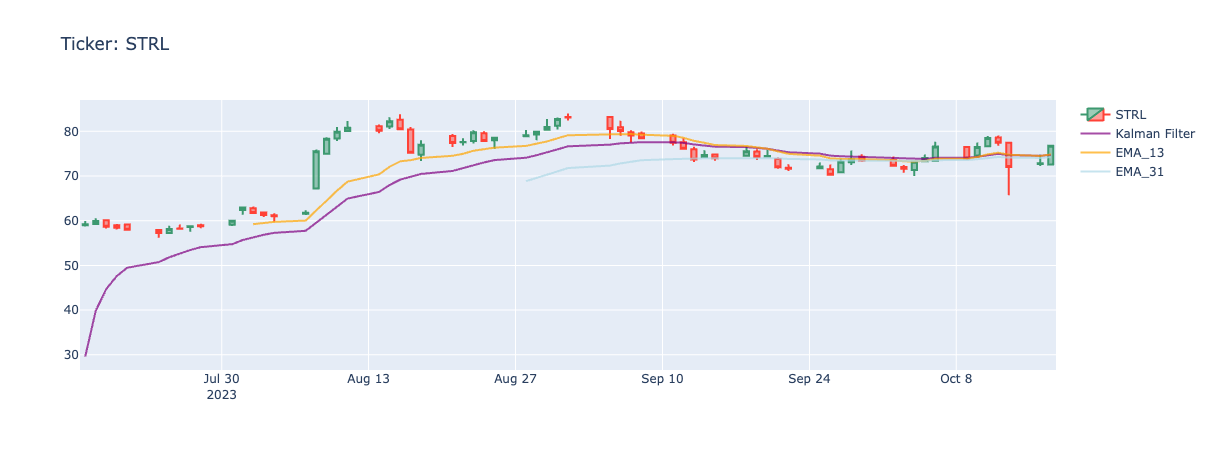

Ticker: LNTH

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 72.80000305175781

Ichimoku 9-Day Forecast: 69.62249946594238

Ichimoku 26-Day Forecast: 68.3849983215332

Choppiness (%): 57.99

RSI: 58.177135178466386

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

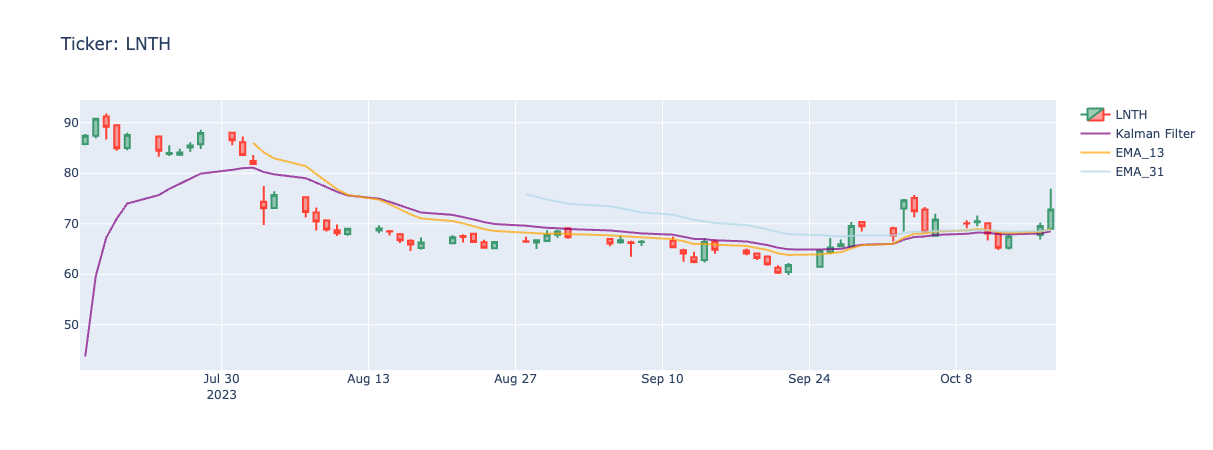

Ticker: BHVN

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 28.65999984741211

Ichimoku 9-Day Forecast: 24.077499866485596

Ichimoku 26-Day Forecast: 22.59500026702881

Choppiness (%): 51.98

RSI: 70.38173368864523

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

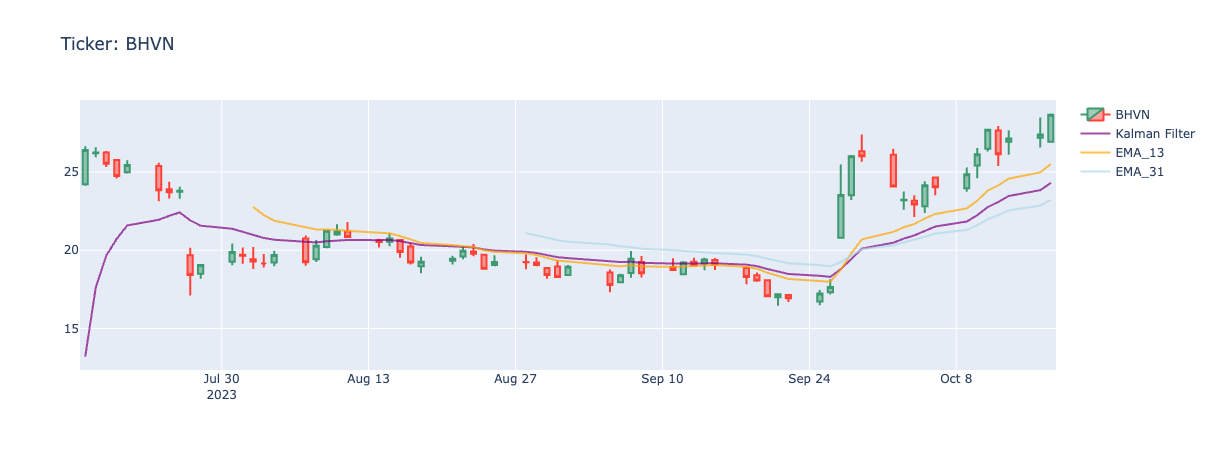

Ticker: URBN

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 34.369998931884766

Ichimoku 9-Day Forecast: 32.50500011444092

Ichimoku 26-Day Forecast: 33.93499946594238

Choppiness (%): 47.74

RSI: 63.85937199613616

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

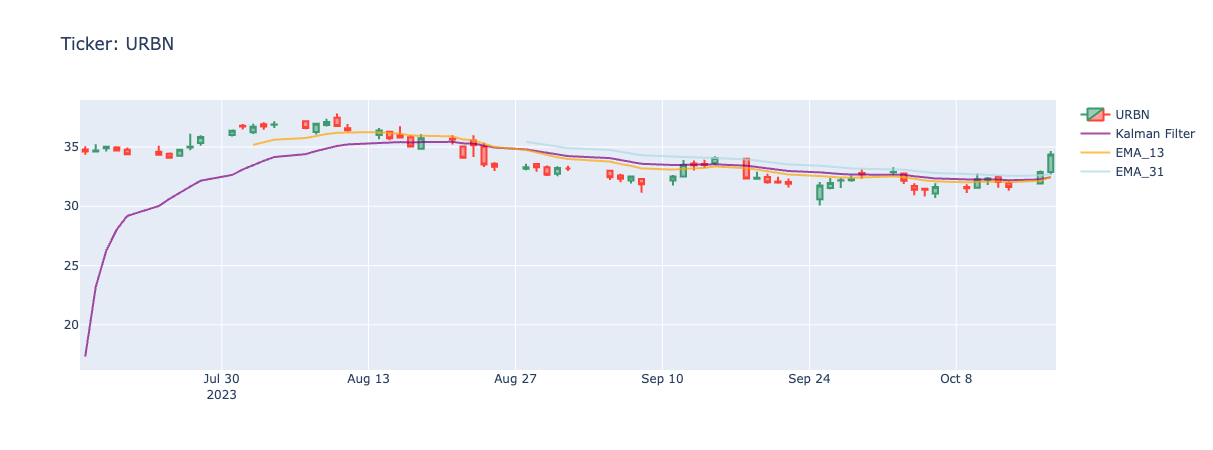

Ticker: GPS

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 12.585000038146973

Ichimoku 9-Day Forecast: 11.204999923706055

Ichimoku 26-Day Forecast: 11.039999961853027

Choppiness (%): 31.85

RSI: 70.43765110248219

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

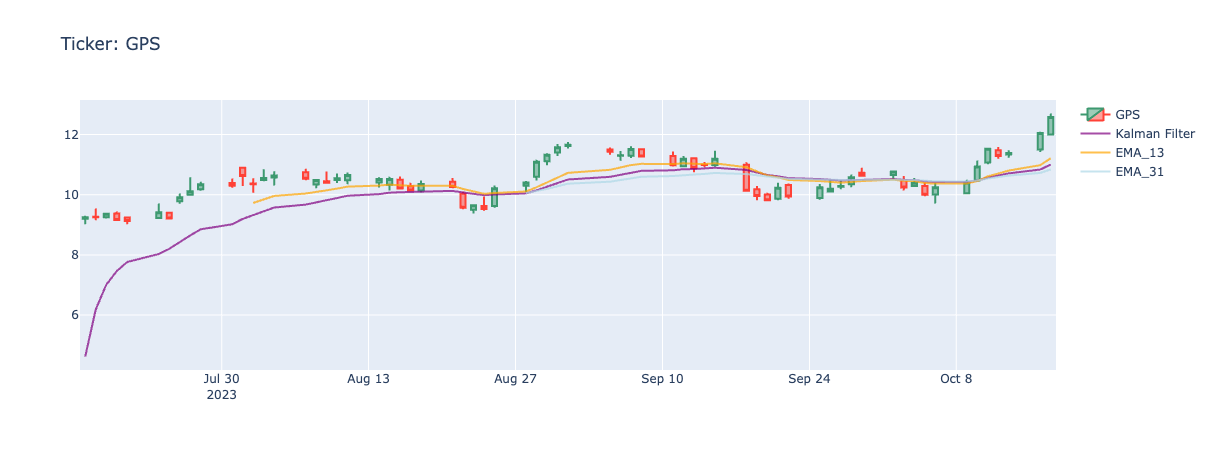

Ticker: AUB

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 30.600000381469727

Ichimoku 9-Day Forecast: 29.330000400543213

Ichimoku 26-Day Forecast: 30.675000190734863

Choppiness (%): 54.18

RSI: 62.85437757747312

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

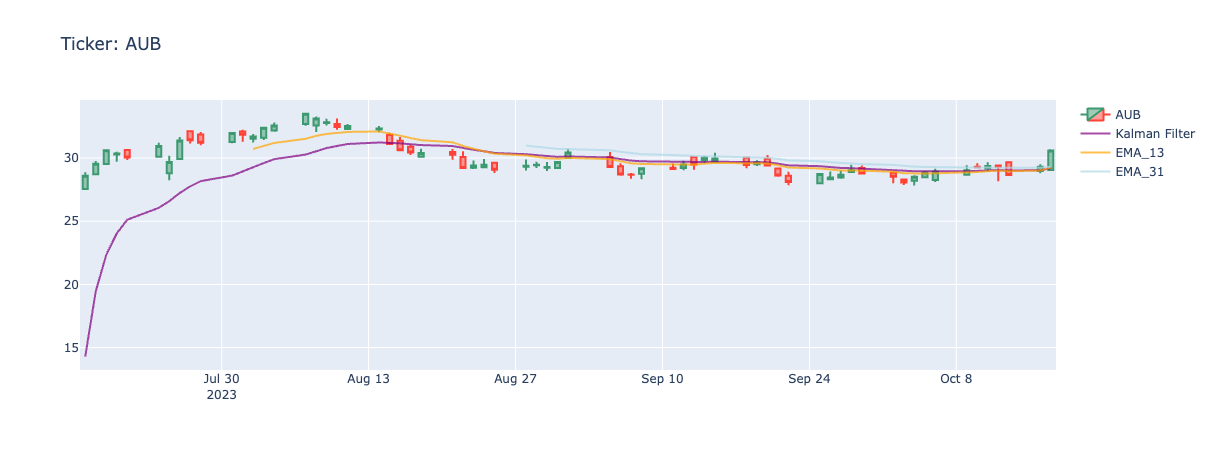

Ticker: FG

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 30.8700008392334

Ichimoku 9-Day Forecast: 28.759999752044678

Ichimoku 26-Day Forecast: 28.655000686645508

Choppiness (%): 38.74

RSI: 66.80064802709164

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

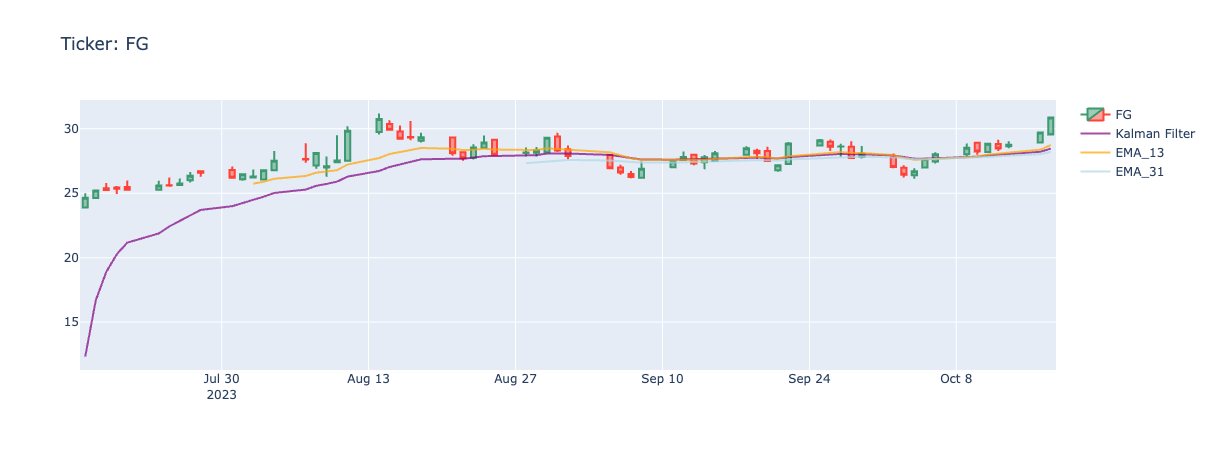

Ticker: KTB

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 46.209999084472656

Ichimoku 9-Day Forecast: 44.09499931335449

Ichimoku 26-Day Forecast: 45.77000045776367

Choppiness (%): 53.10

RSI: 61.907535163895005

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: False

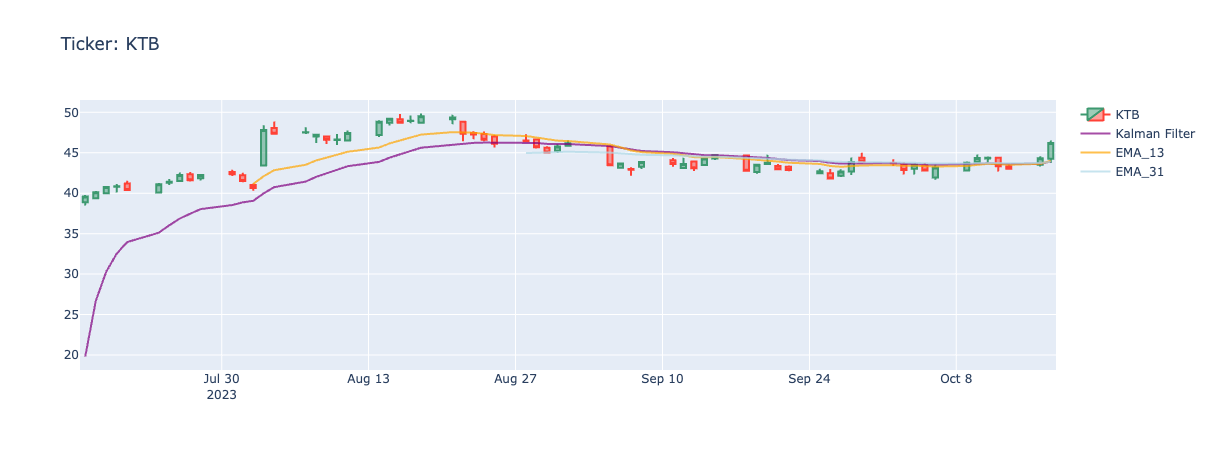

Ticker: SHOO

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 33.599998474121094

Ichimoku 9-Day Forecast: 32.14999961853027

Ichimoku 26-Day Forecast: 33.49000072479248

Choppiness (%): 54.41

RSI: 62.89234468462339

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

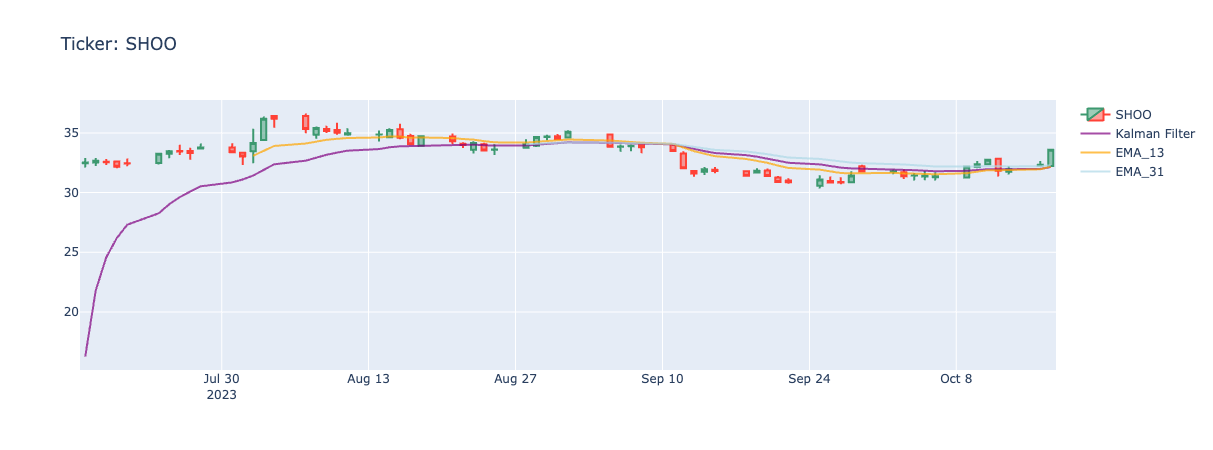

Ticker: MMYT

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 42.13999938964844

Ichimoku 9-Day Forecast: 40.51500129699707

Ichimoku 26-Day Forecast: 37.90999984741211

Choppiness (%): 57.14

RSI: 62.51137914744478

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

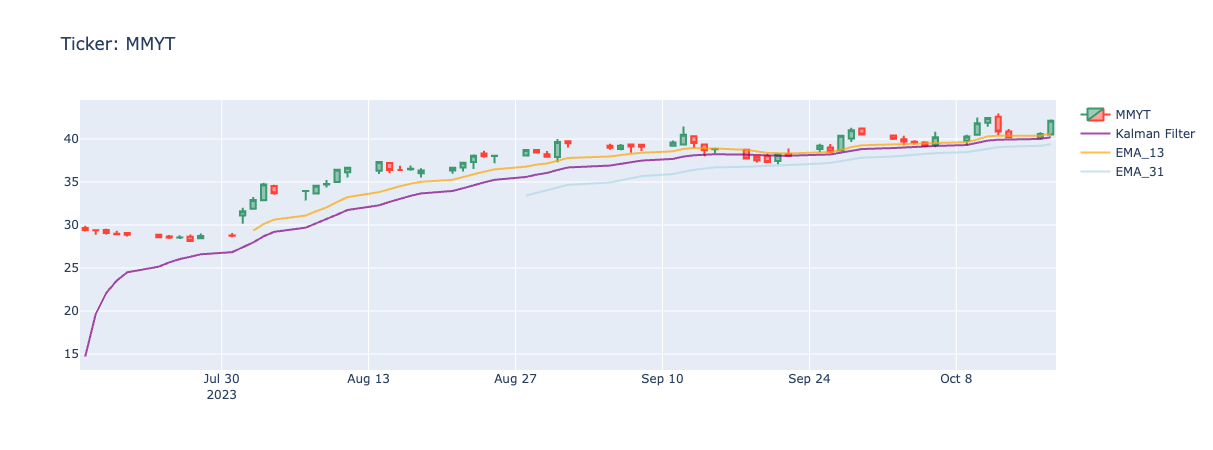

Ticker: RDNT

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 30.545000076293945

Ichimoku 9-Day Forecast: 29.16124963760376

Ichimoku 26-Day Forecast: 30.622499465942383

Choppiness (%): 56.35

RSI: 58.90874617134237

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

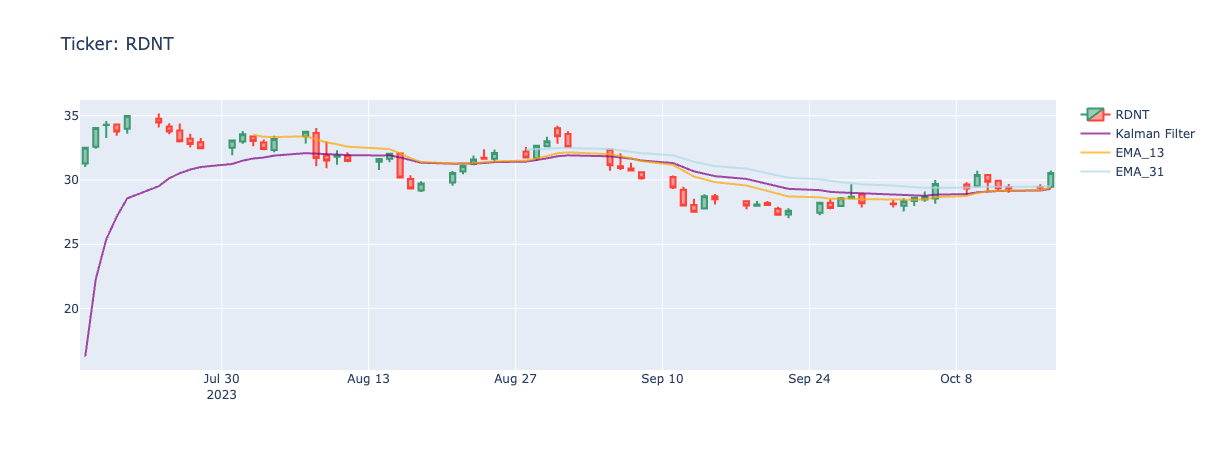

In [5]:
# Plotly within a double nested for-loop. 
# This pulls from Yahoo's Gainers first page, then implements technical indicators to output forecasts, 
# RSI, choppiness, trend archers, & other conditionals to aid in decision making.

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Pull Yahoo's Top Gainers of Today - first page.

url = 'https://finance.yahoo.com/gainers?count=100&offset=0'
headers = {
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'
}

ytext = requests.get(url,headers=headers).text
yroot = lxml.html.fromstring(ytext)
List = []
for x in yroot.xpath('//*[@id="fin-scr-res-table"]//a'):
    List.append({"top_movers":x.attrib['href'].split("/")[-1].split("?")[0]})
List = pd.DataFrame(List)

# calculating plotter
print('\n Entry Points')
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        #calculate_symbol(v)
        if calculate_symbol(v)[8] == True:
            print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman):',calculate_symbol(v)[8])
            print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
            print('\n\nClose:',calculate_symbol(v)[1])
            print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
            print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
            print('Choppiness (%):',calculate_symbol(v)[4])
            print('RSI:',calculate_symbol(v)[5])
            print('Archer MA Trending:',calculate_symbol(v)[6])
            print('EMA_13 > Kalman:',calculate_symbol(v)[7])
            print('Low > Kalman:',calculate_symbol(v)[10])
            plot(v.tail(90),i)
        else:pass
    except:pass

# Exit Points

Exit Points

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: TTOO

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 8.0

Ichimoku 9-Day Forecast: 23.345000505447388

Ichimoku 26-Day Forecast: 38.3199999332428

Choppiness (%): 36.34

RSI: 35.342850077861705

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

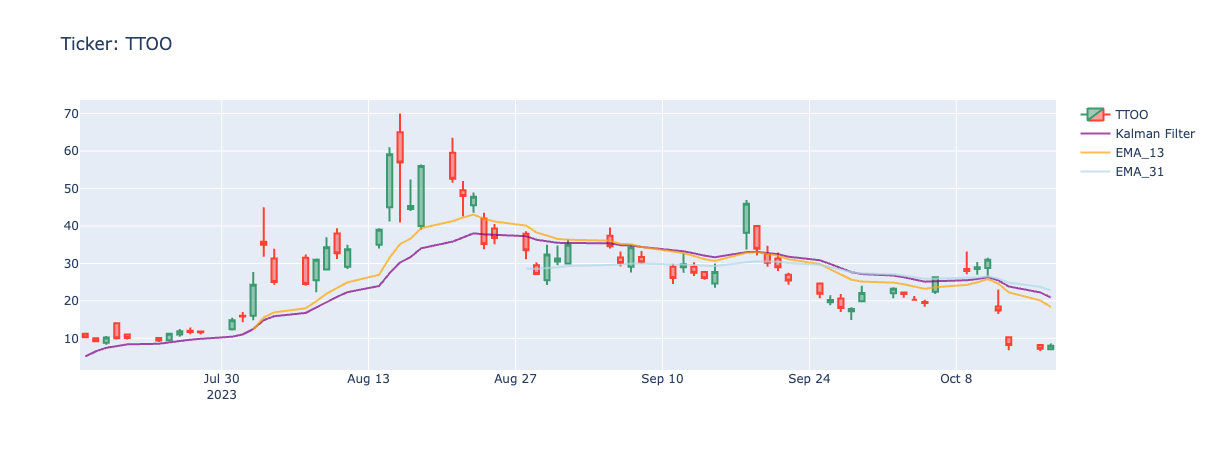

Ticker: SGRY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 25.489999771118164

Ichimoku 9-Day Forecast: 27.074999809265137

Ichimoku 26-Day Forecast: 30.479999542236328

Choppiness (%): 41.16

RSI: 35.282715254935106

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

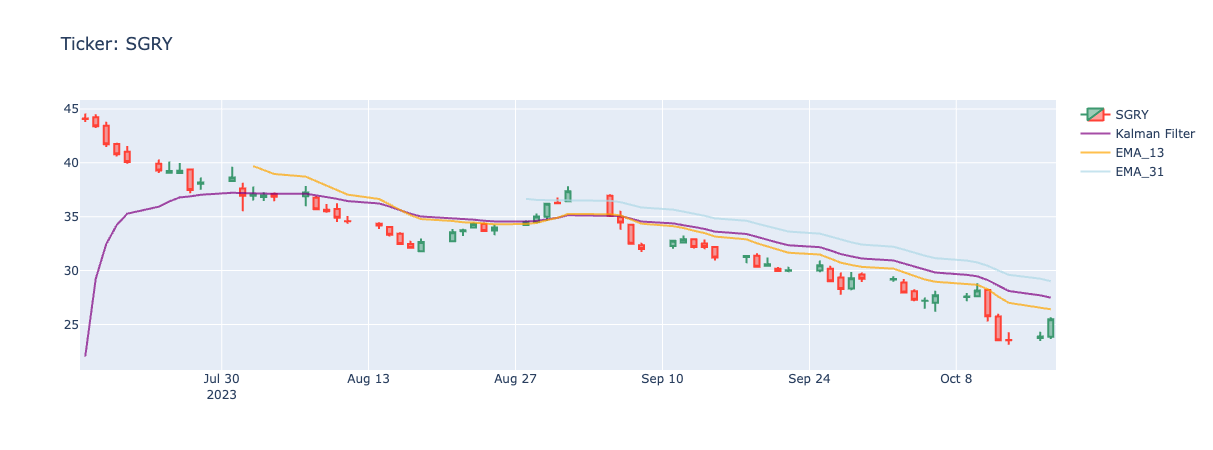

Ticker: SHC

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 14.369999885559082

Ichimoku 9-Day Forecast: 14.099999904632568

Ichimoku 26-Day Forecast: 15.694999694824219

Choppiness (%): 43.99

RSI: 45.014020547918065

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

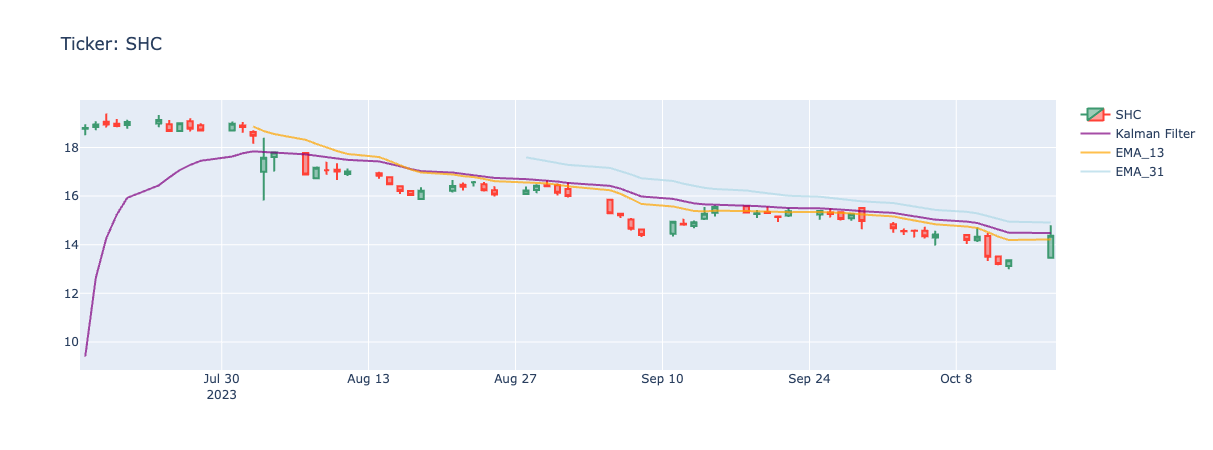

Ticker: THC

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 56.915000915527344

Ichimoku 9-Day Forecast: 60.17999839782715

Ichimoku 26-Day Forecast: 65.66999816894531

Choppiness (%): 37.47

RSI: 33.635512543774816

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

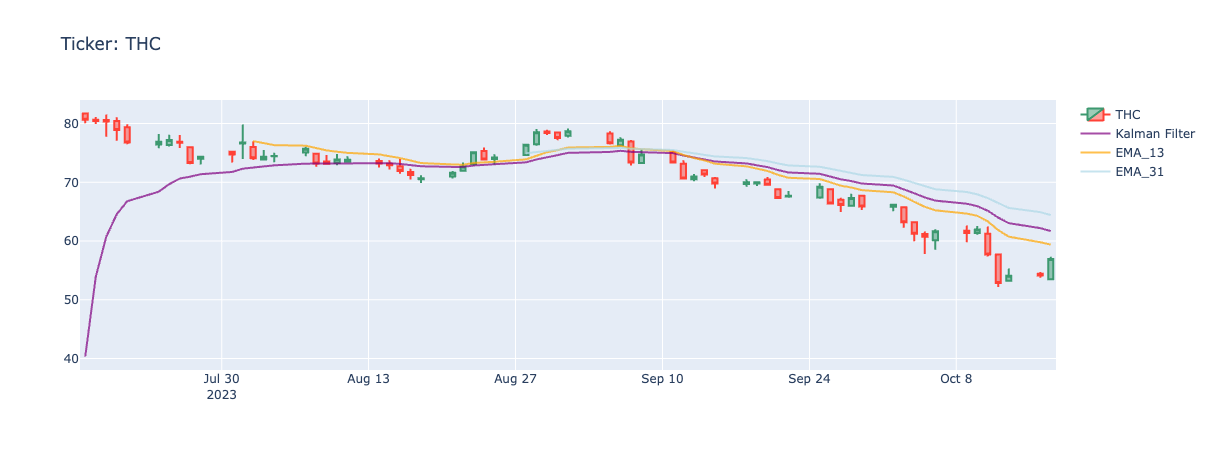

Ticker: MTZ

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 68.66000366210938

Ichimoku 9-Day Forecast: 71.91749954223633

Ichimoku 26-Day Forecast: 84.79999923706055

Choppiness (%): 47.40

RSI: 37.79215503070944

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

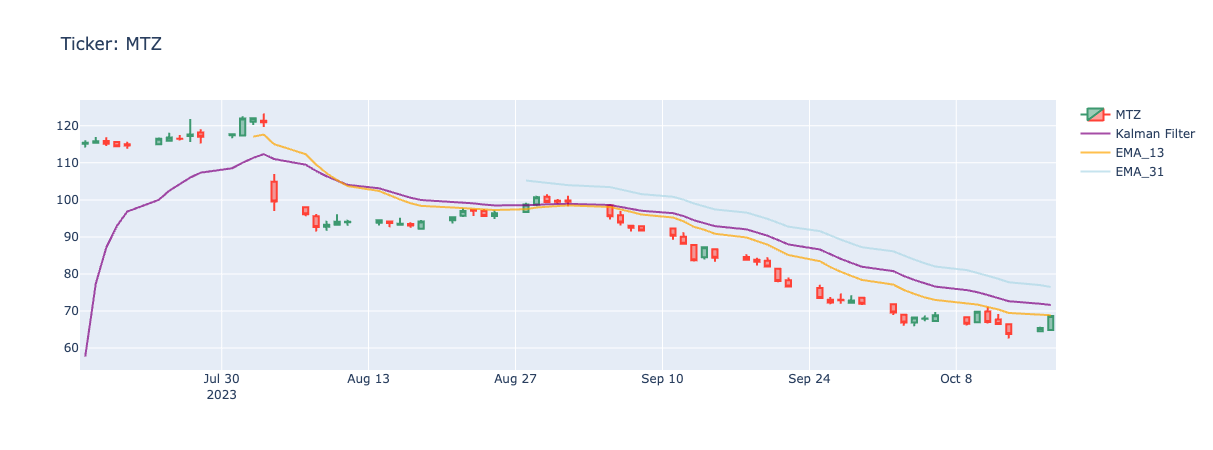

Ticker: GKOS

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 70.24500274658203

Ichimoku 9-Day Forecast: 70.46249961853027

Ichimoku 26-Day Forecast: 72.18000030517578

Choppiness (%): 37.65

RSI: 45.542778503214855

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

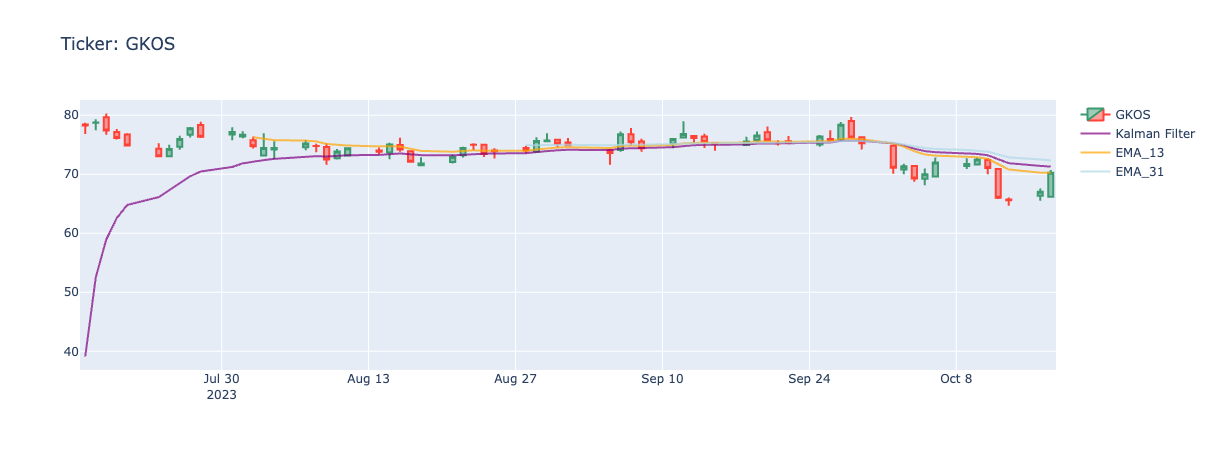

Ticker: INSP

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 157.80999755859375

Ichimoku 9-Day Forecast: 174.98250198364258

Ichimoku 26-Day Forecast: 214.5500030517578

Choppiness (%): 35.61

RSI: 32.4911609138442

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

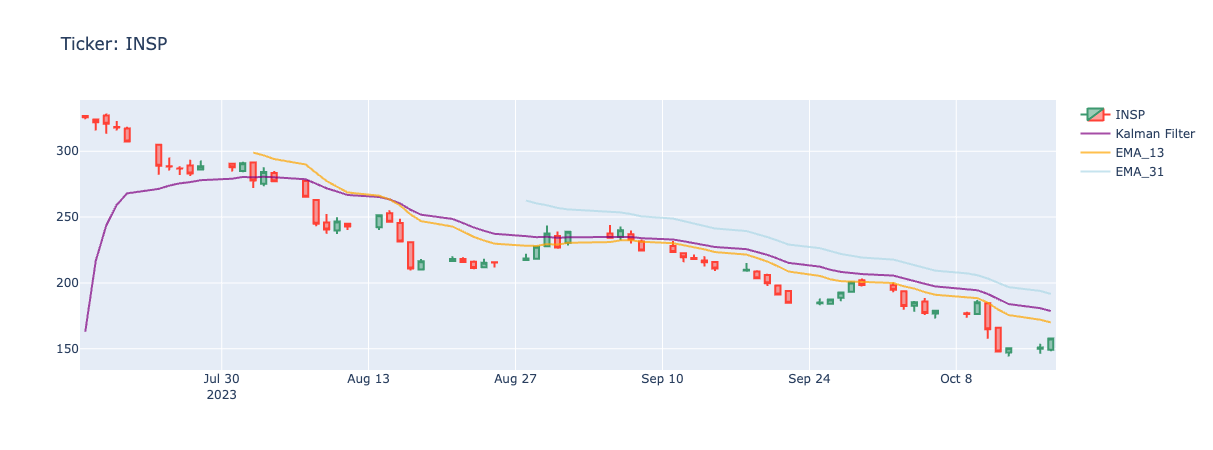

Ticker: SHAK

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 56.25

Ichimoku 9-Day Forecast: 57.05749988555908

Ichimoku 26-Day Forecast: 66.63999938964844

Choppiness (%): 53.09

RSI: 40.80865871648431

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

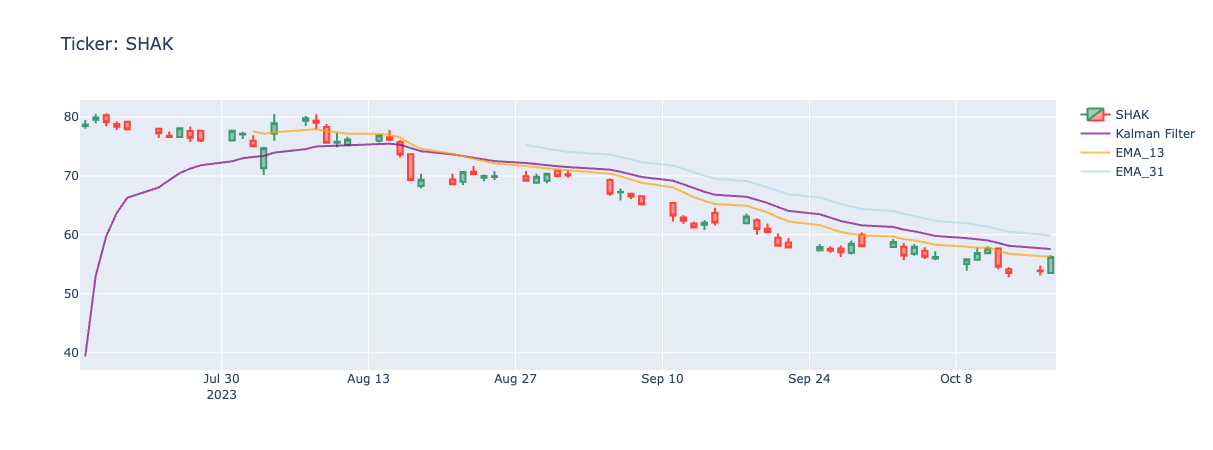

Ticker: NWL

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 7.190000057220459

Ichimoku 9-Day Forecast: 7.759999871253967

Ichimoku 26-Day Forecast: 8.870000123977661

Choppiness (%): 25.57

RSI: 30.805239418211485

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

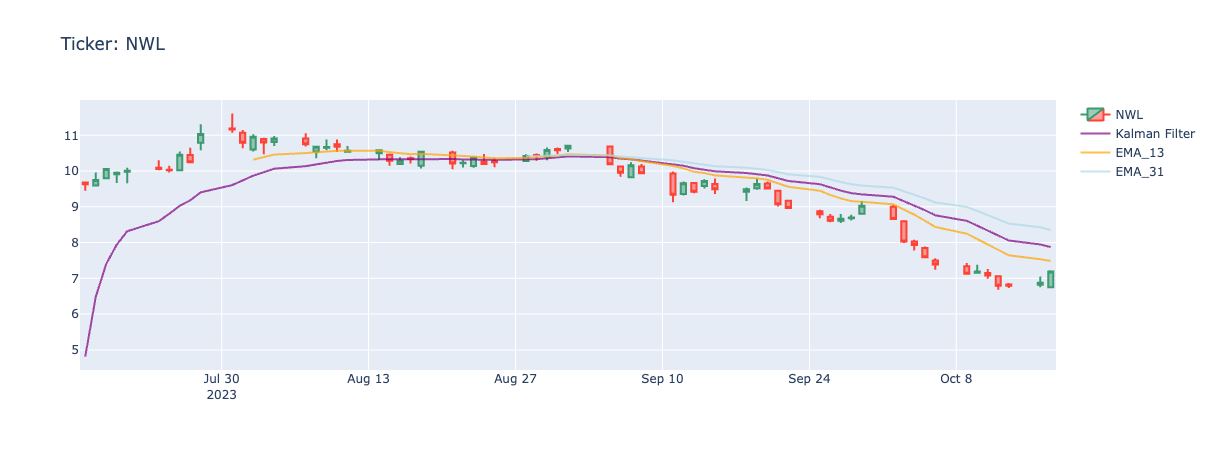

Ticker: NXE

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 5.745699882507324

Ichimoku 9-Day Forecast: 5.787500023841858

Ichimoku 26-Day Forecast: 5.534999847412109

Choppiness (%): 50.44

RSI: 51.503649241080964

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

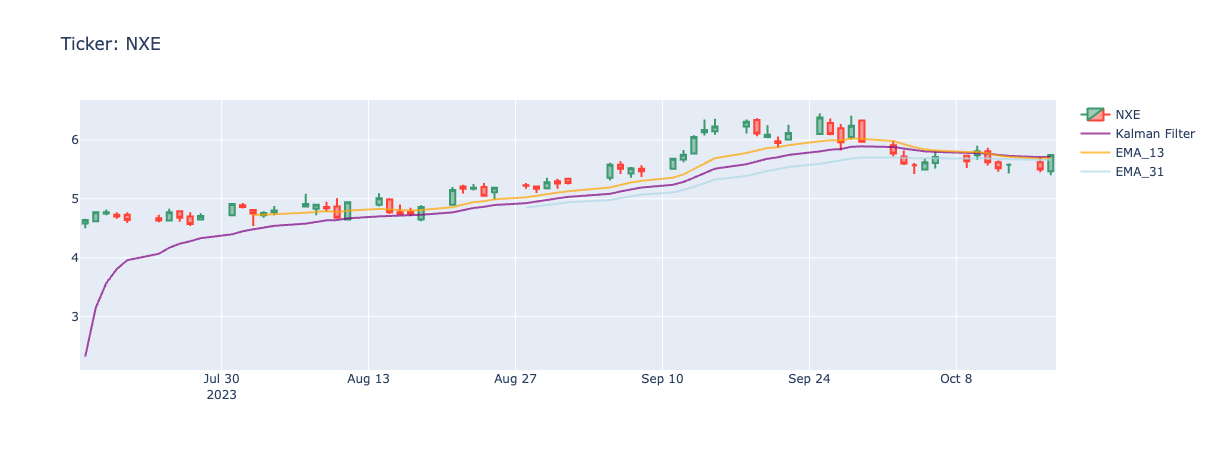

Ticker: JAMF

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 16.350000381469727

Ichimoku 9-Day Forecast: 16.69499969482422

Ichimoku 26-Day Forecast: 18.110000610351562

Choppiness (%): 48.02

RSI: 42.18807713520237

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

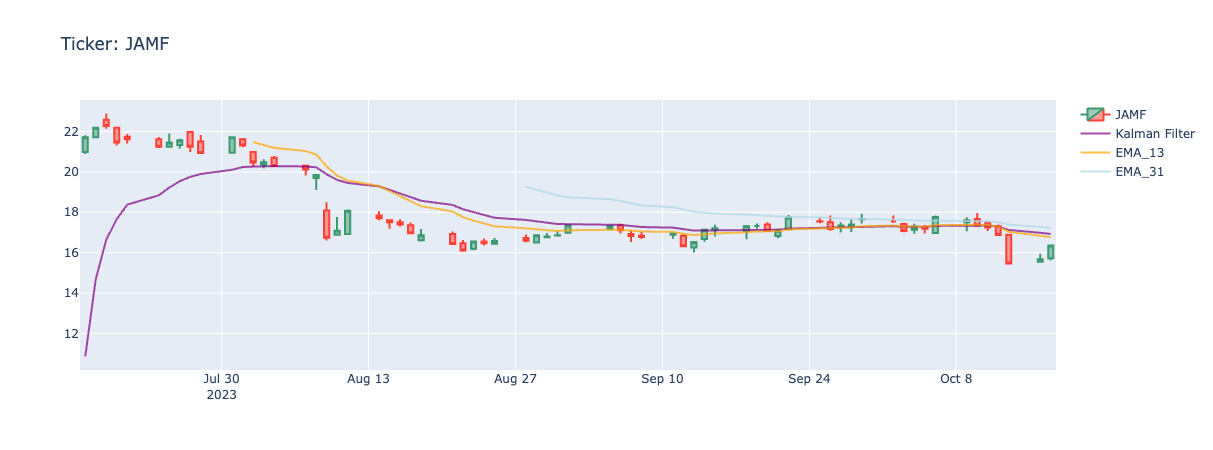

Ticker: DVA

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 77.66999816894531

Ichimoku 9-Day Forecast: 85.27250289916992

Ichimoku 26-Day Forecast: 94.2400016784668

Choppiness (%): 30.18

RSI: 30.18643367098416

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

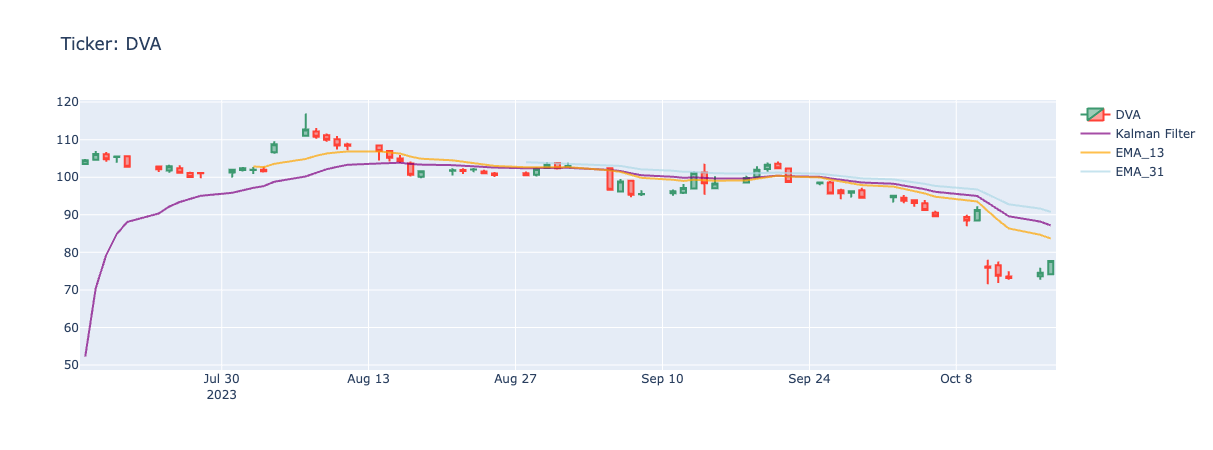

Ticker: TIIAY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 2.7699999809265137

Ichimoku 9-Day Forecast: 2.9137500524520874

Ichimoku 26-Day Forecast: 3.0425000190734863

Choppiness (%): 38.62

RSI: 37.35656898755393

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

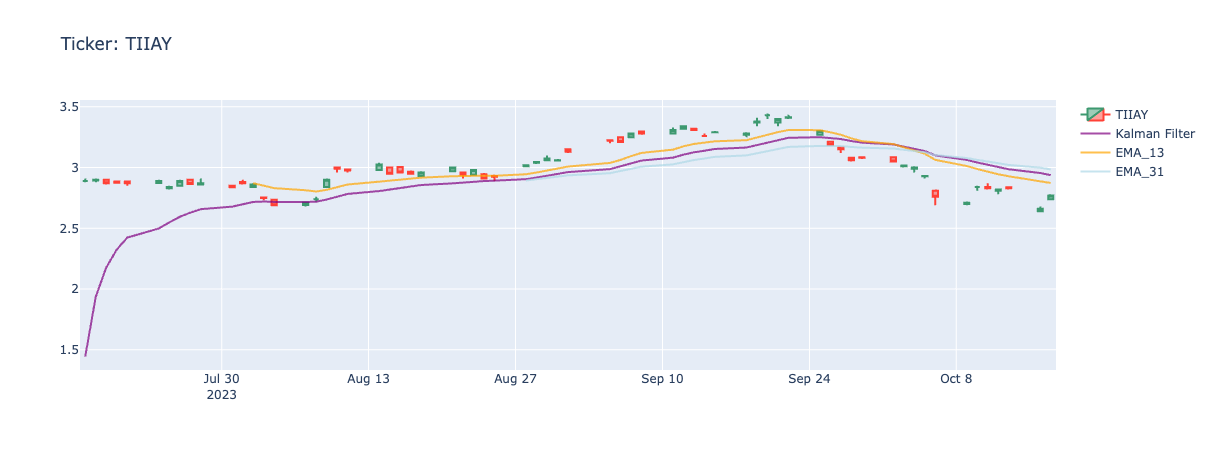

Ticker: PACB

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 8.305000305175781

Ichimoku 9-Day Forecast: 9.067500114440918

Ichimoku 26-Day Forecast: 10.02999997138977

Choppiness (%): 53.49

RSI: 41.122521290260444

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

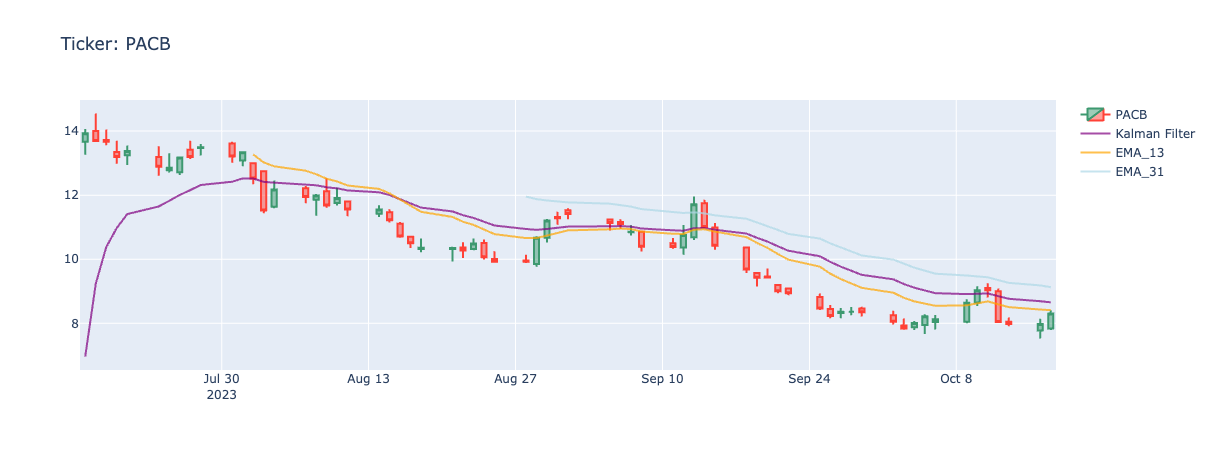

Ticker: CHWY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 18.200000762939453

Ichimoku 9-Day Forecast: 18.707499980926514

Ichimoku 26-Day Forecast: 24.889999389648438

Choppiness (%): 57.99

RSI: 38.557273897258796

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

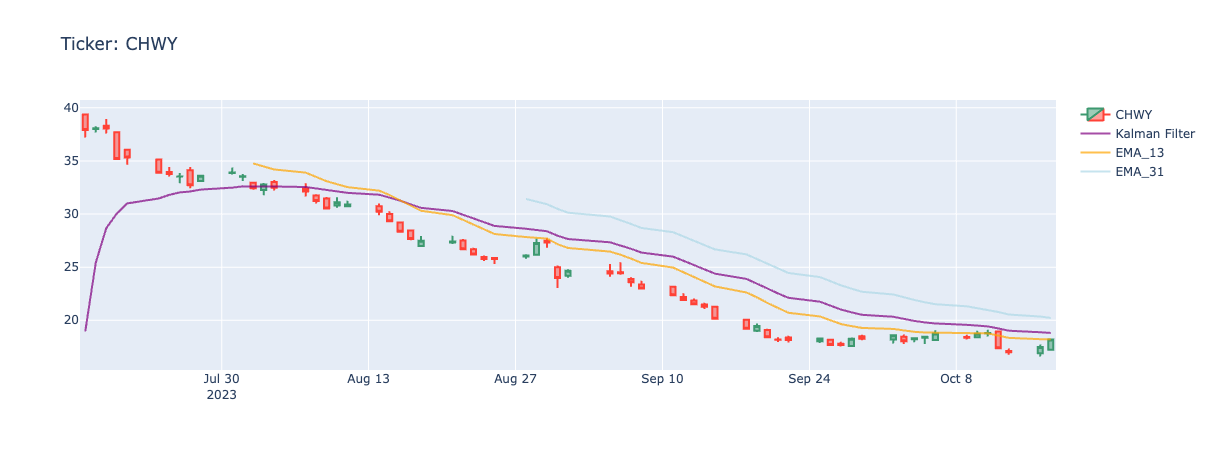

Ticker: COLD

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 28.899999618530273

Ichimoku 9-Day Forecast: 28.730000019073486

Ichimoku 26-Day Forecast: 29.8100004196167

Choppiness (%): 38.65

RSI: 40.921141089222225

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

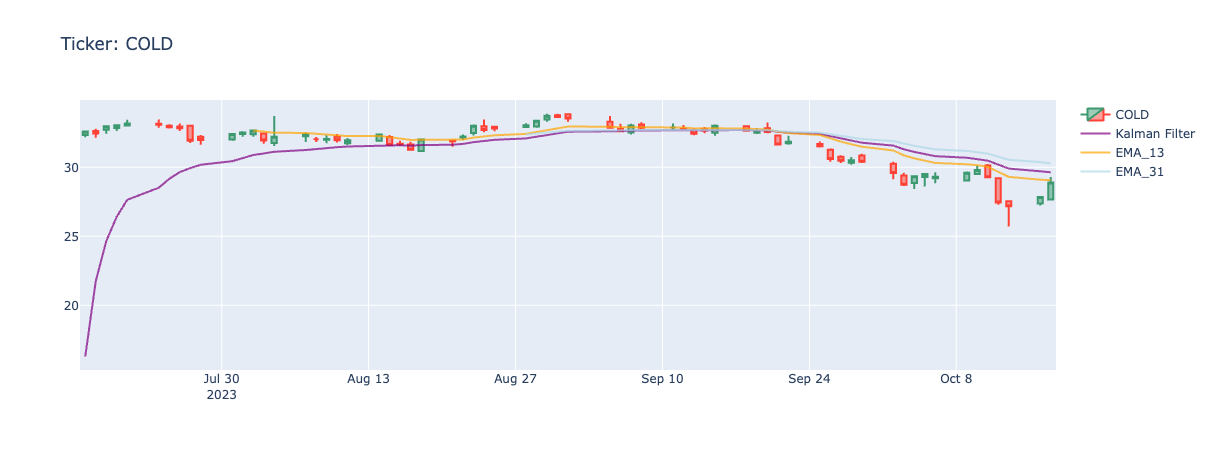

Ticker: PODD

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 141.24000549316406

Ichimoku 9-Day Forecast: 146.98749923706055

Ichimoku 26-Day Forecast: 196.15000534057617

Choppiness (%): 34.73

RSI: 36.50810800105848

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

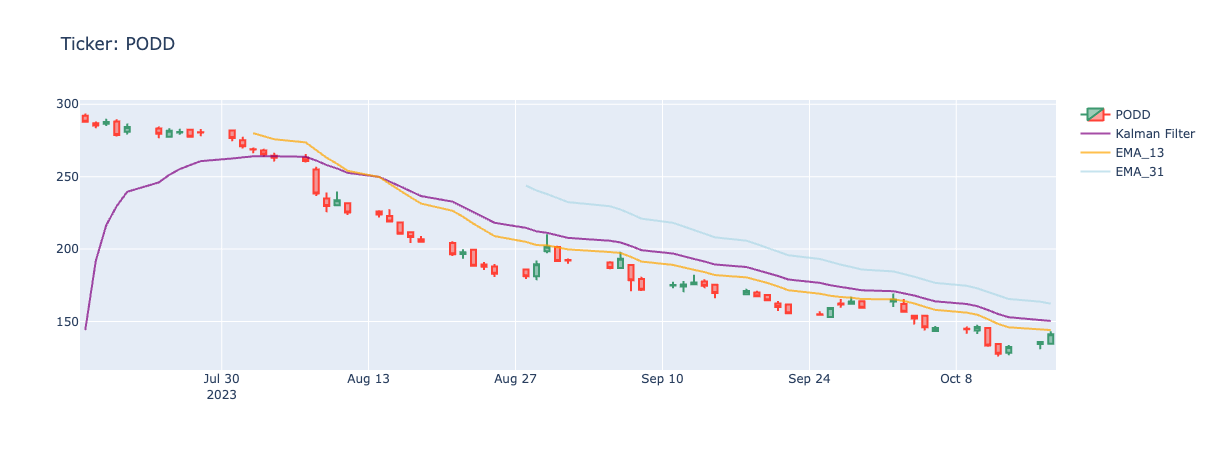

In [6]:
print('\n Exit Points')
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        #calculate_symbol(v)
        if calculate_symbol(v)[9] == True:
            print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman):',calculate_symbol(v)[8])
            print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
            print('\n\nClose:',calculate_symbol(v)[1])
            print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
            print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
            print('Choppiness (%):',calculate_symbol(v)[4])
            print('RSI:',calculate_symbol(v)[5])
            print('Archer MA Trending:',calculate_symbol(v)[6])
            print('EMA_13 > Kalman:',calculate_symbol(v)[7])
            print('Low > Kalman:',calculate_symbol(v)[10])
            plot(v.tail(90),i)
        else:pass
    except:pass

In [7]:
# choppiness
print("Choppiness:")
help(ta.chop)

Choppiness:

Help on function chop in module pandas_ta.trend.chop:

chop(high, low, close, length=None, atr_length=None, ln=None, scalar=None, drift=None, offset=None, **kwargs)
    Choppiness Index (CHOP)
    
    The Choppiness Index was created by Australian commodity trader
    E.W. Dreiss and is designed to determine if the market is choppy
    (trading sideways) or not choppy (trading within a trend in either
    direction). Values closer to 100 implies the underlying is choppier
    whereas values closer to 0 implies the underlying is trending.
    
    Sources:
        https://www.tradingview.com/scripts/choppinessindex/
        https://www.motivewave.com/studies/choppiness_index.htm
    
    Calculation:
        Default Inputs:
            length=14, scalar=100, drift=1
        HH = high.rolling(length).max()
        LL = low.rolling(length).min()
    
        ATR_SUM = SUM(ATR(drift), length)
        CHOP = scalar * (LOG10(ATR_SUM) - LOG10(HH - LL))
        CHOP /= LOG10(length)
    
    

In [8]:
# Archer Moving Averages Trends
# https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb
# https://www.tradingview.com/script/Z2mq63fE-Trade-Archer-Moving-Averages-v1-4F/

In [9]:
# en fin